In [11]:
# Import libraries 
from pyspark import SparkFiles
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import explode, split
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.sql.functions import log, col
from pyspark.ml.feature import MinMaxScaler
from pyspark.sql import functions as F
from pyspark.ml.feature import RFormula
from pyspark.sql import DataFrame
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.stat import Correlation
import pandas as pd
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [12]:
# Start spark session
spark = SparkSession.builder.appName('Spark-Group1-Linear-Regression').getOrCreate()

In [3]:
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

## Loading Data

### Loading train dataset (75% of the data) after feature engineering 

In [4]:
# Load train dataset
train_transformed_gcs_path = "gs://msca-bdp-student-gcs/Group1/lr_data/traindata_transformed/"

# Read the CSV file from GCS
df_train = spark.read.parquet(train_transformed_gcs_path, header=True, inferSchema=True)

df_train.show(10)

+--------------------+----------+----------+--------------+-----------+------------+---------+--------------+----------------+--------+--------+-----------------+------------+---------------+-------------+-----------------+-------------------+----------------------+-------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+
|               legId|searchDate|flightDate|travelDuration|elapsedDays|isRefundable|totalFare|seatsRemaining|DaysBeforeFlight|Layovers|NumStops|NumUniqueAirlines|AircraftType|NumUniqueCabins|hasFirstClass|FlightArrivalDate|totalTravelDistance|startingAirport_onehot|destinationAirport_onehot|AirlineName_0_onehot|AirlineName_1_onehot|AirlineName_2_onehot|AirlineName_3_onehot|AirlineName_4_onehot|    log_totalFare|
+--------------------+----------+----------+--------------+-----------+------------+---------+--------------+----------------+--------+--------+-----------------+------

### Loading test dataset (15% of the data) after feature engineering 

In [5]:
# Load train dataset
test_transformed_gcs_path = "gs://msca-bdp-student-gcs/Group1/lr_data/testdata_transformed/"

# Read the CSV file from GCS
df_test = spark.read.parquet(test_transformed_gcs_path, header=True, inferSchema=True)

df_test.show(10)

+--------------------+----------+----------+--------------+-----------+------------+---------+--------------+----------------+--------+--------+-----------------+------------+---------------+-------------+-----------------+-------------------+----------------------+-------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+
|               legId|searchDate|flightDate|travelDuration|elapsedDays|isRefundable|totalFare|seatsRemaining|DaysBeforeFlight|Layovers|NumStops|NumUniqueAirlines|AircraftType|NumUniqueCabins|hasFirstClass|FlightArrivalDate|totalTravelDistance|startingAirport_onehot|destinationAirport_onehot|AirlineName_0_onehot|AirlineName_1_onehot|AirlineName_2_onehot|AirlineName_3_onehot|AirlineName_4_onehot|    log_totalFare|
+--------------------+----------+----------+--------------+-----------+------------+---------+--------------+----------------+--------+--------+-----------------+------

### Loading validation dataset (10% of the data) after feature engineering 

In [6]:
# Load train dataset
val_transformed_gcs_path = "gs://msca-bdp-student-gcs/Group1/lr_data/valdata_transformed/"

# Read the CSV file from GCS
df_val = spark.read.parquet(val_transformed_gcs_path, header=True, inferSchema=True)

df_val.show(10)

+--------------------+----------+----------+--------------+-----------+------------+---------+--------------+----------------+----------+--------+-----------------+------------+---------------+-------------+-----------------+-------------------+----------------------+-------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+
|               legId|searchDate|flightDate|travelDuration|elapsedDays|isRefundable|totalFare|seatsRemaining|DaysBeforeFlight|  Layovers|NumStops|NumUniqueAirlines|AircraftType|NumUniqueCabins|hasFirstClass|FlightArrivalDate|totalTravelDistance|startingAirport_onehot|destinationAirport_onehot|AirlineName_0_onehot|AirlineName_1_onehot|AirlineName_2_onehot|AirlineName_3_onehot|AirlineName_4_onehot|     log_totalFare|
+--------------------+----------+----------+--------------+-----------+------------+---------+--------------+----------------+----------+--------+----------------

### Repartition data

In [8]:
# Repartition train data
num = df_train.rdd.getNumPartitions()
print(num)
df_train = df_train.repartition(num)

20


In [9]:
# Repartition test data
num = df_test.rdd.getNumPartitions()
print(num)
df_test = df_test.repartition(num)

4


In [10]:
# Repartition validation data
num = df_val.rdd.getNumPartitions()
print(num)
df_val = df_val.repartition(num)

5


In [7]:
# Combine datasets
combined_df = df_train.union(df_test).union(df_val)

# Calculate average totalFare across combined dataset
overall_avg = combined_df.agg({"log_totalFare": "mean"}).collect()[0][0]

print(f"Overall average log_totalFare: {overall_avg}")

Overall average log_totalFare: 5.672836468428886


# Baseline model

### Linear Regression benchmark model based on features with moderate to high correlation with the target variable

In [8]:
# Assemble feature vector
feature_columns = [
    "DaysBeforeFlight", "NumStops", "NumUniqueAirlines", "NumUniqueCabins", 
    "travelDuration", "isRefundable", "hasFirstClass", "totalTravelDistance",
    "AircraftType", "seatsRemaining", "elapsedDays"
]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_train_baseline = assembler.transform(df_train)

In [9]:
# Train the Linear Regression Model
lr = LinearRegression(featuresCol="features", labelCol="log_totalFare") 
lr_model = lr.fit(df_train_baseline)

24/12/01 02:27:39 WARN org.apache.spark.ml.util.Instrumentation: [e3d2d9cf] regParam is zero, which might cause numerical instability and overfitting.
24/12/01 02:28:35 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
24/12/01 02:28:35 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
24/12/01 02:28:35 WARN com.github.fommil.netlib.LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
24/12/01 02:28:35 WARN com.github.fommil.netlib.LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


In [10]:
# Make predictions on the train dataset
predictions = lr_model.transform(df_train_baseline)

# Evaluate metrics
evaluator_rmse = RegressionEvaluator(labelCol="log_totalFare", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="log_totalFare", predictionCol="prediction", metricName="r2")
evaluator_mae = RegressionEvaluator(labelCol="log_totalFare", predictionCol="prediction", metricName="mae")

train_rmse = evaluator_rmse.evaluate(predictions)
train_r2 = evaluator_r2.evaluate(predictions)
train_mae = evaluator_mae.evaluate(predictions)

# Print results
print("Evaluation Metrics on Train Dataset:")
print(f"RMSE: {train_rmse:.4f}")
print(f"R2: {train_r2:.4f}")
print(f"MAE: {train_mae:.4f}")

Evaluation Metrics on Train Dataset:
RMSE: 0.4602
R2: 0.3664
MAE: 0.3641


In [11]:
# Sample 10% of the predictions DataFrame 
sampled_predictions = predictions.sample(fraction=0.1, seed=42)
# Convert the sampled Spark DataFrame to a Pandas DataFrame for plotting
sampled_predictions_pd = sampled_predictions.select("log_totalFare", "prediction").toPandas()
sampled_predictions_pd["residuals"] = sampled_predictions_pd["log_totalFare"] - sampled_predictions_pd["prediction"]

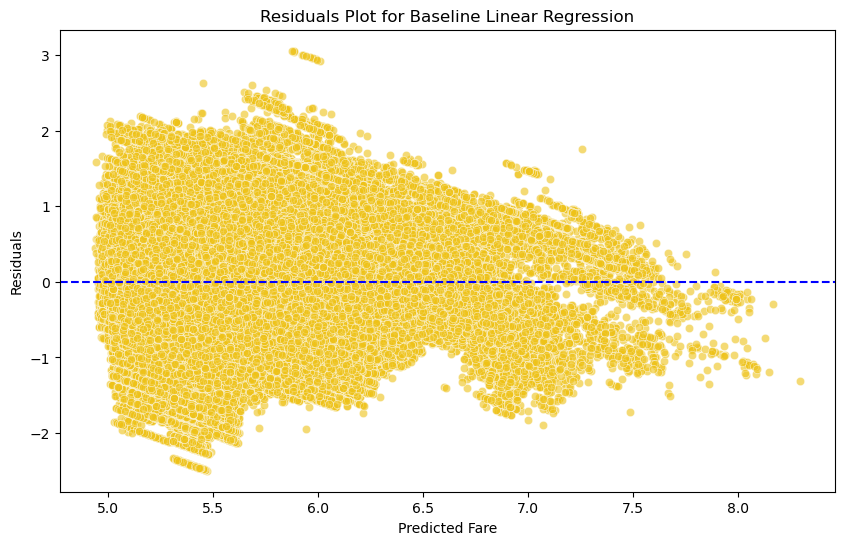

In [12]:
# Residuals Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=sampled_predictions_pd["prediction"], y=sampled_predictions_pd["residuals"], color="#EEC218", alpha=0.6)
plt.axhline(y=0, color='blue', linestyle='--')
plt.xlabel("Predicted Fare")
plt.ylabel("Residuals")
plt.title("Residuals Plot for Baseline Linear Regression")
plt.show()

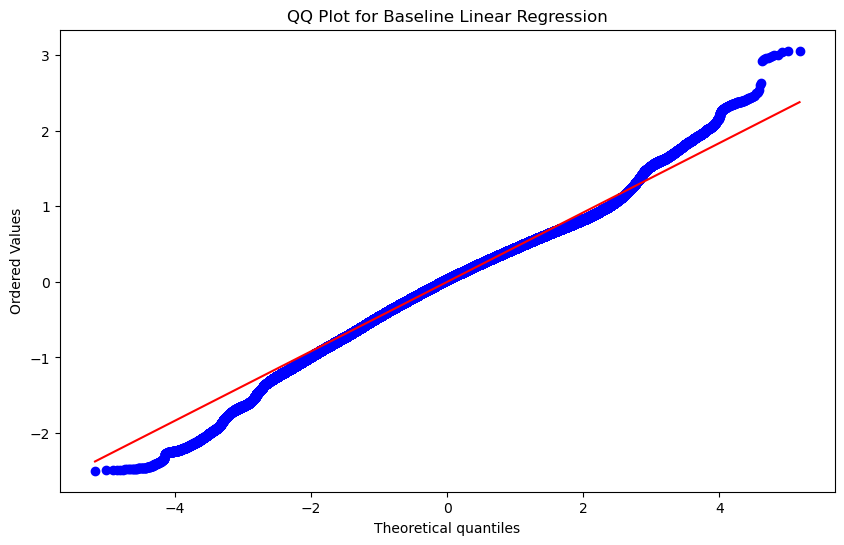

In [13]:
# QQ Plot
plt.figure(figsize=(10, 6))
stats.probplot(sampled_predictions_pd["residuals"], dist="norm", plot=plt)
plt.title("QQ Plot for Baseline Linear Regression")
plt.show()

# Feature Selection

## Backward Elimination

In [24]:
# Define columns to exclude
exclude_columns = ["legId", "searchDate", "flightDate", "FlightArrivalDate", "Layovers", "totalFare", "log_totalFare",
                  "AirlineName_1_onehot","AirlineName_2_onehot","AirlineName_3_onehot","AirlineName_4_onehot"]

all_columns = df_train.columns
feature_columns = [col for col in all_columns if col not in exclude_columns]

# Initialize selected features with all feature columns
selected_features = feature_columns.copy()
target_column = "log_totalFare"

In [25]:
# Initialize a Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol=target_column)

# Initialize a RegressionEvaluator to evaluate RMSE
evaluator = RegressionEvaluator(labelCol=target_column, predictionCol="prediction", metricName="rmse")

In [26]:
# Backward elimination loop
previous_rmse = float('inf')  # Initialize previous RMSE
improvement_threshold = 0.001  # Minimum improvement in RMSE
no_improvement_count = 0  # Count of iterations without improvement
max_no_improvement_count = 3  # Stop if no improvement for this many iterations

while selected_features:
    # Assemble features for the current selection
    assembler = VectorAssembler(inputCols=selected_features, outputCol="features")
    df_assembled_train = assembler.transform(df_train)

    # Train the model
    model = lr.fit(df_assembled_train)

    # Assemble features for the validation set
    df_assembled_val = assembler.transform(df_val)

    # Evaluate the model performance on validation set
    predictions = model.transform(df_assembled_val)
    rmse = evaluator.evaluate(predictions)
    print(f"Current RMSE with features {selected_features}: {rmse}")

    # Check for improvement in RMSE
    if previous_rmse - rmse > improvement_threshold:
        previous_rmse = rmse
        no_improvement_count = 0  # Reset counter if improvement is found

        # Get feature coefficients
        coefficients = model.coefficients
        feature_importance = list(zip(selected_features, coefficients))

        # Find the feature with the lowest absolute coefficient
        least_important_feature = min(feature_importance, key=lambda x: abs(x[1]))[0]
        
        print(f"Removing feature: {least_important_feature} with RMSE: {rmse}")
        selected_features.remove(least_important_feature)  # Remove least important feature

    else:
        no_improvement_count += 1
        print(f"No significant improvement. Count without improvement: {no_improvement_count}")

    # Stop if no improvement for max_no_improvement_count iterations
    if no_improvement_count >= max_no_improvement_count:
        print("Stopping early due to no significant improvement.")
        break

#Results
print(f"Final selected features: {selected_features}")

24/12/02 04:50:17 WARN org.apache.spark.ml.util.Instrumentation: [72b9b595] regParam is zero, which might cause numerical instability and overfitting.


Current RMSE with features ['travelDuration', 'elapsedDays', 'isRefundable', 'seatsRemaining', 'DaysBeforeFlight', 'NumStops', 'NumUniqueAirlines', 'AircraftType', 'NumUniqueCabins', 'hasFirstClass', 'totalTravelDistance', 'startingAirport_onehot', 'destinationAirport_onehot', 'AirlineName_0_onehot']: 0.42324415828817236
Removing feature: totalTravelDistance with RMSE: 0.42324415828817236


24/12/02 04:52:18 WARN org.apache.spark.ml.util.Instrumentation: [bfecc647] regParam is zero, which might cause numerical instability and overfitting.


Current RMSE with features ['travelDuration', 'elapsedDays', 'isRefundable', 'seatsRemaining', 'DaysBeforeFlight', 'NumStops', 'NumUniqueAirlines', 'AircraftType', 'NumUniqueCabins', 'hasFirstClass', 'startingAirport_onehot', 'destinationAirport_onehot', 'AirlineName_0_onehot']: 0.4388050163069077
No significant improvement. Count without improvement: 1


24/12/02 04:54:13 WARN org.apache.spark.ml.util.Instrumentation: [f5e4ef62] regParam is zero, which might cause numerical instability and overfitting.
24/12/02 04:56:07 WARN org.apache.spark.ml.util.Instrumentation: [51b7d1e8] regParam is zero, which might cause numerical instability and overfitting.


Current RMSE with features ['travelDuration', 'elapsedDays', 'isRefundable', 'seatsRemaining', 'DaysBeforeFlight', 'NumStops', 'NumUniqueAirlines', 'AircraftType', 'NumUniqueCabins', 'hasFirstClass', 'startingAirport_onehot', 'destinationAirport_onehot', 'AirlineName_0_onehot']: 0.4388050163069077
No significant improvement. Count without improvement: 2


Current RMSE with features ['travelDuration', 'elapsedDays', 'isRefundable', 'seatsRemaining', 'DaysBeforeFlight', 'NumStops', 'NumUniqueAirlines', 'AircraftType', 'NumUniqueCabins', 'hasFirstClass', 'startingAirport_onehot', 'destinationAirport_onehot', 'AirlineName_0_onehot']: 0.4388050163069077
No significant improvement. Count without improvement: 3
Stopping early due to no significant improvement.
Final selected features: ['travelDuration', 'elapsedDays', 'isRefundable', 'seatsRemaining', 'DaysBeforeFlight', 'NumStops', 'NumUniqueAirlines', 'AircraftType', 'NumUniqueCabins', 'hasFirstClass', 'startingAirport_onehot', 'destinationAirport_onehot', 'AirlineName_0_onehot']


## Forward Selection

In [27]:
# Excluding all AirlineName columns except the first one as we believe that would carry more weight in 
# its correlation with fare
# and including subsequent columns would be very computationally heavy
exclude_columns = ["legId", "searchDate", "flightDate", "FlightArrivalDate", "Layovers", "totalFare", "log_totalFare",
                   "AirlineName_1_onehot","AirlineName_2_onehot","AirlineName_3_onehot","AirlineName_4_onehot"]
all_columns = df_train.columns
feature_selection_columns = [col for col in all_columns if col not in exclude_columns]

print(f"Features considered for selection: {feature_selection_columns}")

# Initialize variables for forward feature selection
target_column = "log_totalFare"
selected_features = []
remaining_features = feature_selection_columns.copy()

Features considered for selection: ['travelDuration', 'elapsedDays', 'isRefundable', 'seatsRemaining', 'DaysBeforeFlight', 'NumStops', 'NumUniqueAirlines', 'AircraftType', 'NumUniqueCabins', 'hasFirstClass', 'totalTravelDistance', 'startingAirport_onehot', 'destinationAirport_onehot', 'AirlineName_0_onehot']


In [28]:
# Create an initial VectorAssembler
assembler = VectorAssembler(inputCols=selected_features, outputCol="features_selected")

# Cache train and validation datasets to optimize repeated reads
df_train.cache()
df_val.cache()

DataFrame[legId: string, searchDate: date, flightDate: date, travelDuration: int, elapsedDays: int, isRefundable: int, totalFare: double, seatsRemaining: int, DaysBeforeFlight: int, Layovers: array<string>, NumStops: int, NumUniqueAirlines: int, AircraftType: int, NumUniqueCabins: int, hasFirstClass: int, FlightArrivalDate: date, totalTravelDistance: int, startingAirport_onehot: vector, destinationAirport_onehot: vector, AirlineName_0_onehot: vector, AirlineName_1_onehot: vector, AirlineName_2_onehot: vector, AirlineName_3_onehot: vector, AirlineName_4_onehot: vector, log_totalFare: double]

In [29]:
# Initialize a linear regression model
lr = LinearRegression(featuresCol="features_selected", labelCol=target_column)  

# Initialize a RegressionEvaluator to evaluate R2
evaluator = RegressionEvaluator(labelCol=target_column, predictionCol="prediction", metricName="r2")


In [ ]:
# Forward selection loop
while remaining_features:
    # Assemble features for all remaining columns in a single step
    test_features = [selected_features + [feature] for feature in remaining_features]
    feature_r2 = []

    for feature_set in test_features:
        assembler = VectorAssembler(inputCols=feature_set, outputCol="features_selected")
        
        # Transform train and validation datasets
        df_train_assembled = assembler.transform(df_train)
        df_val_assembled = assembler.transform(df_val)
        
        # Train and evaluate model
        model = lr.fit(df_train_assembled)
        predictions = model.transform(df_val_assembled)
        r2 = evaluator.evaluate(predictions)
        
        # Append results
        feature_r2.append((feature_set[-1], r2))  # Track feature and corresponding R2

    # Find the best feature in this round
    best_feature, highest_r2 = max(feature_r2, key=lambda x: x[1])  # Look for the highest R2

    # Update selected features
    selected_features.append(best_feature)
    remaining_features.remove(best_feature)
    print(f"Selected Feature: {best_feature} with R2: {highest_r2}")
    
    # Early stopping if no significant improvement
    if len(feature_r2) > 1 and abs(feature_r2[-2][1] - highest_r2) < 1e-3:
        print("No significant improvement in R2. Stopping early.")
        break

# Results
print("Final Selected Features:", selected_features)

24/12/02 05:00:40 WARN org.apache.spark.ml.util.Instrumentation: [c6ccca1c] regParam is zero, which might cause numerical instability and overfitting.
24/12/02 05:03:53 WARN org.apache.spark.ml.util.Instrumentation: [fa21b790] regParam is zero, which might cause numerical instability and overfitting.
24/12/02 05:04:49 WARN org.apache.spark.ml.util.Instrumentation: [ab131d73] regParam is zero, which might cause numerical instability and overfitting.
24/12/02 05:05:41 WARN org.apache.spark.ml.util.Instrumentation: [dd850760] regParam is zero, which might cause numerical instability and overfitting.
24/12/02 05:06:37 WARN org.apache.spark.ml.util.Instrumentation: [57ce36ff] regParam is zero, which might cause numerical instability and overfitting.
24/12/02 05:07:29 WARN org.apache.spark.ml.util.Instrumentation: [ff1c3870] regParam is zero, which might cause numerical instability and overfitting.
24/12/02 05:08:23 WARN org.apache.spark.ml.util.Instrumentation: [19cb856b] regParam is zero, 

Selected Feature: totalTravelDistance with R2: 0.2489996370195613


24/12/02 05:17:03 WARN org.apache.spark.ml.util.Instrumentation: [7c00453e] regParam is zero, which might cause numerical instability and overfitting.
24/12/02 05:18:02 WARN org.apache.spark.ml.util.Instrumentation: [d24230a2] regParam is zero, which might cause numerical instability and overfitting.
24/12/02 05:19:06 WARN org.apache.spark.ml.util.Instrumentation: [b26fd642] regParam is zero, which might cause numerical instability and overfitting.
24/12/02 05:20:19 WARN org.apache.spark.ml.util.Instrumentation: [531b2ea9] regParam is zero, which might cause numerical instability and overfitting.
24/12/02 05:22:31 WARN org.apache.spark.ml.util.Instrumentation: [3fa0c0fc] regParam is zero, which might cause numerical instability and overfitting.
24/12/02 05:24:43 WARN org.apache.spark.ml.util.Instrumentation: [ebaacd97] regParam is zero, which might cause numerical instability and overfitting.
24/12/02 05:26:45 WARN org.apache.spark.ml.util.Instrumentation: [a241dcab] regParam is zero, 

Selected Feature: AirlineName_0_onehot with R2: 0.34210374848391967


24/12/02 05:37:49 WARN org.apache.spark.ml.util.Instrumentation: [76abe026] regParam is zero, which might cause numerical instability and overfitting.
24/12/02 05:39:34 WARN org.apache.spark.ml.util.Instrumentation: [4d18152b] regParam is zero, which might cause numerical instability and overfitting.
24/12/02 05:41:07 WARN org.apache.spark.ml.util.Instrumentation: [8c42e599] regParam is zero, which might cause numerical instability and overfitting.
24/12/02 05:43:01 WARN org.apache.spark.ml.util.Instrumentation: [97e8e94d] regParam is zero, which might cause numerical instability and overfitting.
24/12/02 05:44:51 WARN org.apache.spark.ml.util.Instrumentation: [19545fc6] regParam is zero, which might cause numerical instability and overfitting.
24/12/02 05:46:40 WARN org.apache.spark.ml.util.Instrumentation: [e29f45dd] regParam is zero, which might cause numerical instability and overfitting.
24/12/02 05:48:19 WARN org.apache.spark.ml.util.Instrumentation: [e1eac7a7] regParam is zero, 

Selected Feature: NumUniqueAirlines with R2: 0.40199154655391023


24/12/02 05:56:30 WARN org.apache.spark.ml.util.Instrumentation: [97572180] regParam is zero, which might cause numerical instability and overfitting.
24/12/02 05:57:54 WARN org.apache.spark.ml.util.Instrumentation: [abd16bfb] regParam is zero, which might cause numerical instability and overfitting.
24/12/02 05:59:44 WARN org.apache.spark.ml.util.Instrumentation: [f334e002] regParam is zero, which might cause numerical instability and overfitting.
24/12/02 06:01:17 WARN org.apache.spark.ml.util.Instrumentation: [f4d3960e] regParam is zero, which might cause numerical instability and overfitting.
24/12/02 06:02:32 WARN org.apache.spark.ml.util.Instrumentation: [156a8108] regParam is zero, which might cause numerical instability and overfitting.
24/12/02 06:03:50 WARN org.apache.spark.ml.util.Instrumentation: [38341cf1] regParam is zero, which might cause numerical instability and overfitting.
24/12/02 06:05:09 WARN org.apache.spark.ml.util.Instrumentation: [904f59b8] regParam is zero, 

Selected Feature: startingAirport_onehot with R2: 0.4163988319011632
No significant improvement in R2. Stopping early.
Final Selected Features: ['totalTravelDistance', 'AirlineName_0_onehot', 'NumUniqueAirlines', 'startingAirport_onehot']


## RFE

In [10]:
# Specify the columns to exclude
exclude_columns = ["legId", "searchDate", "flightDate", "FlightArrivalDate", 
                   "Layovers", "totalFare", "log_totalFare",
                  "AirlineName_0_onehot","AirlineName_1_onehot","AirlineName_2_onehot",
                   "AirlineName_3_onehot","AirlineName_4_onehot"]

# Get the list of features by excluding specified columns
feature_columns = [col for col in df_train.columns if col not in exclude_columns]

# Defining 5 features to select
num_features_to_select = 5  

selected_features = feature_columns.copy()

In [ ]:
while len(selected_features) > num_features_to_select:
    # Create a VectorAssembler to assemble feature columns into a feature vector
    assembler = VectorAssembler(inputCols=selected_features, outputCol="features")
    
    # Define the linear regression model
    lr = LinearRegression(featuresCol="features", labelCol="log_totalFare")

    # Create a Pipeline
    pipeline = Pipeline(stages=[assembler, lr])
    
    # Fit the model on the training data
    model = pipeline.fit(df_train)

    # Get model coefficients for feature importance
    coefficients = model.stages[1].coefficients
    
    # Create a list of feature names and their importance
    feature_importance = [(feature, coef) for feature, coef in zip(selected_features, coefficients)]

    # Remove the least important feature
    least_important_feature = min(feature_importance, key=lambda x: abs(x[1]))[0]
    selected_features.remove(least_important_feature)

24/12/01 06:38:43 WARN org.apache.spark.ml.util.Instrumentation: [cb90e42c] regParam is zero, which might cause numerical instability and overfitting.
24/12/01 06:39:55 WARN com.github.fommil.netlib.LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
24/12/01 06:39:55 WARN com.github.fommil.netlib.LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK
24/12/01 06:41:05 WARN org.apache.spark.ml.util.Instrumentation: [11107438] regParam is zero, which might cause numerical instability and overfitting.
24/12/01 06:43:21 WARN org.apache.spark.ml.util.Instrumentation: [ea6dd9b5] regParam is zero, which might cause numerical instability and overfitting.
24/12/01 06:45:31 WARN org.apache.spark.ml.util.Instrumentation: [358e6867] regParam is zero, which might cause numerical instability and overfitting.
24/12/01 06:47:37 WARN org.apache.spark.ml.util.Instrumentation: [a3d6f6f3] regParam is zero, which might cause numerical insta

In [ ]:
# Fit the model again with selected features to get final coefficients
assembler = VectorAssembler(inputCols=selected_features, outputCol="features")
df_train_assembled = assembler.transform(df_train)
final_model = lr.fit(df_train_assembled)

# Final feature importance after RFE
final_coefficients = final_model.coefficients
final_feature_importance = [(feature, coef) for feature, coef in zip(selected_features, final_coefficients)]

# Sort features by their absolute importance
final_feature_importance_sorted = sorted(final_feature_importance, key=lambda x: abs(x[1]), reverse=True)

# Results
print("Selected Features and Their Importance:")
for feature, importance in final_feature_importance_sorted:
    print(f"{feature}: {importance}")

24/12/01 06:55:26 WARN org.apache.spark.ml.util.Instrumentation: [760787a0] regParam is zero, which might cause numerical instability and overfitting.


Selected Features and Their Importance:
hasFirstClass: 1.3278395012032225
isRefundable: 0.7317203377608316
NumUniqueAirlines: 0.4851550536720447
NumStops: 0.278124549402716
destinationAirport_onehot: 0.04688989436786634


# Modelling

## Using Backward Elimination Features

### Linear Regression Using Backward Elimination Features with Interaction Term

##### NumUniqueCabins and hasFirstClass have a correlation of 0.52

In [21]:
# Create interaction terms
df_train = df_train.withColumn("NumUniqueCabins_hasFirstClass", col("NumUniqueCabins") * col("hasFirstClass"))


feature_columns = ['travelDuration', 'elapsedDays', 'isRefundable', 'seatsRemaining', 'DaysBeforeFlight', 
                   'NumStops', 'NumUniqueAirlines', 'AircraftType', 'NumUniqueCabins', 'hasFirstClass', 
                   'startingAirport_onehot', 'destinationAirport_onehot', 'AirlineName_0_onehot','NumUniqueCabins_hasFirstClass']

In [22]:
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_train_lr = assembler.transform(df_train)

# Evaluate metrics
evaluator_rmse = RegressionEvaluator(labelCol="log_totalFare", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="log_totalFare", predictionCol="prediction", metricName="r2")
evaluator_mae = RegressionEvaluator(labelCol="log_totalFare", predictionCol="prediction", metricName="mae")

In [23]:
# Train the Linear Regression Model
lr = LinearRegression(featuresCol="features", labelCol="log_totalFare") 
lr_model = lr.fit(df_train_lr)

24/12/02 17:32:03 WARN org.apache.spark.ml.util.Instrumentation: [86592a4f] regParam is zero, which might cause numerical instability and overfitting.


In [24]:
# Make predictions on the train dataset
predictions = lr_model.transform(df_train_lr)

train_rmse = evaluator_rmse.evaluate(predictions)
train_r2 = evaluator_r2.evaluate(predictions)
train_mae = evaluator_mae.evaluate(predictions)

# Print results
print("Evaluation Metrics on Train Dataset:")
print(f"RMSE: {train_rmse:.4f}")
print(f"R2: {train_r2:.4f}")
print(f"MAE: {train_mae:.4f}")

Evaluation Metrics on Train Dataset:
RMSE: 0.4384
R2: 0.4252
MAE: 0.3474


### L1 Regression Using Backward Elimination Features with Interaction Term

In [25]:
# Train the L1 Lasso model
lr_l1 = LinearRegression(featuresCol="features", labelCol="log_totalFare", regParam=0.1, elasticNetParam=1.0)
lr_model_l1 = lr_l1.fit(df_train_lr)

In [26]:
# Make predictions on train data
predictions_l1 = lr_model_l1.transform(df_train_lr)

# Evaluate metrics
train_rmse_l1 = evaluator_rmse.evaluate(predictions_l1)
train_r2_l1 = evaluator_r2.evaluate(predictions_l1)
train_mae_l1 = evaluator_mae.evaluate(predictions_l1)

# Print results
print("Evaluation Metrics on Train Dataset:")
print(f"RMSE: {train_rmse_l1:.4f}")
print(f"R2: {train_r2_l1:.4f}")
print(f"MAE: {train_mae_l1:.4f}")

Evaluation Metrics on Train Dataset:
RMSE: 0.5002
R2: 0.2515
MAE: 0.3996


### L2 Regression Using Backward Elimination Features with Interaction Term

In [27]:
# Train the L2 model
lr_l2 = LinearRegression(featuresCol="features", labelCol="log_totalFare", regParam=0.1, elasticNetParam=0.0)
lr_model_l2 = lr_l2.fit(df_train_lr)

In [ ]:
# Make predictions on train data
predictions_l2 = lr_model_l2.transform(df_train_lr)

train_rmse_l2 = evaluator_rmse.evaluate(predictions_l2)
train_r2_l2 = evaluator_r2.evaluate(predictions_l2)
train_mae_l2 = evaluator_mae.evaluate(predictions_l2)

# Print results
print("Evaluation Metrics on Train Dataset:")
print(f"RMSE: {train_rmse_l2:.4f}")
print(f"R2: {train_r2_l2:.4f}")
print(f"MAE: {train_mae_l2:.4f}")

Evaluation Metrics on Train Dataset:
RMSE: 0.4422
R2: 0.4150
MAE: 0.3494


## Using Forward Selection Features

### Linear Regression Using Forward Selection Features

In [13]:
feature_columns = ["totalTravelDistance","NumUniqueAirlines","startingAirport_onehot","AirlineName_0_onehot"]

In [14]:
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_train_lr = assembler.transform(df_train)

# Evaluate metrics
evaluator_rmse = RegressionEvaluator(labelCol="log_totalFare", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="log_totalFare", predictionCol="prediction", metricName="r2")
evaluator_mae = RegressionEvaluator(labelCol="log_totalFare", predictionCol="prediction", metricName="mae")

In [15]:
# Train the Linear Regression Model
lr = LinearRegression(featuresCol="features", labelCol="log_totalFare") 
lr_model = lr.fit(df_train_lr)

24/12/02 17:19:29 WARN org.apache.spark.ml.util.Instrumentation: [0a0c10c0] regParam is zero, which might cause numerical instability and overfitting.
24/12/02 17:20:25 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
24/12/02 17:20:25 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
24/12/02 17:20:26 WARN com.github.fommil.netlib.LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
24/12/02 17:20:26 WARN com.github.fommil.netlib.LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


In [16]:
# Make predictions on the train dataset
predictions = lr_model.transform(df_train_lr)

train_rmse = evaluator_rmse.evaluate(predictions)
train_r2 = evaluator_r2.evaluate(predictions)
train_mae = evaluator_mae.evaluate(predictions)

# Print results
print("Evaluation Metrics on Train Dataset:")
print(f"RMSE: {train_rmse:.4f}")
print(f"R2: {train_r2:.4f}")
print(f"MAE: {train_mae:.4f}")

Evaluation Metrics on Train Dataset:
RMSE: 0.4417
R2: 0.4165
MAE: 0.3488


### L1 Regression Using Forward Selection Features

In [17]:
# Train the L1 Lasso model
lr_l1 = LinearRegression(featuresCol="features", labelCol="log_totalFare", regParam=0.1, elasticNetParam=1.0)
lr_model_l1 = lr_l1.fit(df_train_lr)

In [18]:
# Make predictions on train data
predictions_l1 = lr_model_l1.transform(df_train_lr)

# Evaluate metrics
train_rmse_l1 = evaluator_rmse.evaluate(predictions_l1)
train_r2_l1 = evaluator_r2.evaluate(predictions_l1)
train_mae_l1 = evaluator_mae.evaluate(predictions_l1)

# Print results
print("Evaluation Metrics on Train Dataset:")
print(f"RMSE: {train_rmse_l1:.4f}")
print(f"R2: {train_r2_l1:.4f}")
print(f"MAE: {train_mae_l1:.4f}")

Evaluation Metrics on Train Dataset:
RMSE: 0.4844
R2: 0.2981
MAE: 0.3851


### L2 Regression Using Forward Selection Features

In [19]:
# Train the L2 model
lr_l2 = LinearRegression(featuresCol="features", labelCol="log_totalFare", regParam=0.1, elasticNetParam=0.0)
lr_model_l2 = lr_l2.fit(df_train_lr)

In [20]:
# Make predictions on train data
predictions_l2 = lr_model_l2.transform(df_train_lr)

train_rmse_l2 = evaluator_rmse.evaluate(predictions_l2)
train_r2_l2 = evaluator_r2.evaluate(predictions_l2)
train_mae_l2 = evaluator_mae.evaluate(predictions_l2)

# Print results
print("Evaluation Metrics on Train Dataset:")
print(f"RMSE: {train_rmse_l2:.4f}")
print(f"R2: {train_r2_l2:.4f}")
print(f"MAE: {train_mae_l2:.4f}")

Evaluation Metrics on Train Dataset:
RMSE: 0.4446
R2: 0.4087
MAE: 0.3507


## Using RFE Features

### Linear Regression Using RFE Features

In [14]:
# Defining features and creating vector assembler for the following models
feature_columns = ['isRefundable', 'NumStops', 
                   'NumUniqueAirlines', 'hasFirstClass',  'destinationAirport_onehot']


assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_train_lr = assembler.transform(df_train)
df_test_lr = assembler.transform(df_test)

# Evaluate metrics
evaluator_rmse = RegressionEvaluator(labelCol="log_totalFare", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="log_totalFare", predictionCol="prediction", metricName="r2")
evaluator_mae = RegressionEvaluator(labelCol="log_totalFare", predictionCol="prediction", metricName="mae")

In [15]:
# Train the Linear Regression Model
lr = LinearRegression(featuresCol="features", labelCol="log_totalFare") 
lr_model = lr.fit(df_train_lr)

24/12/02 04:38:35 WARN org.apache.spark.ml.util.Instrumentation: [63d6e54e] regParam is zero, which might cause numerical instability and overfitting.


In [16]:
# Make predictions on the train dataset
predictions = lr_model.transform(df_train_lr)

train_rmse = evaluator_rmse.evaluate(predictions)
train_r2 = evaluator_r2.evaluate(predictions)
train_mae = evaluator_mae.evaluate(predictions)

# Print results
print("Evaluation Metrics on Train Dataset:")
print(f"RMSE: {train_rmse:.4f}")
print(f"R2: {train_r2:.4f}")
print(f"MAE: {train_mae:.4f}")

Evaluation Metrics on Train Dataset:
RMSE: 0.4968
R2: 0.2619
MAE: 0.3899
